Jupyter notebook for fitting a two-parameter Fermi (2pF) distribution to a Compton Edge in order to determine the point half-way down the Compton edge. Provision of an energy calibration allows this position to be converted from channels to keV.

The notebook reads in .Spe data files generated by Maestro software programme. It reads a foreground data file, a background data file and subtracts the background data from the foreground data. It plots the background-subtracted data in order to determine the limits of the fit to be chosen. It then fits the background and plots the result.

Step 1: Import various program modules

Step 2: Input input and output filenames (Before running, upload your foreground and background data files to your Jupyter working directory)

Step 3: Read data from the foreground and background data files

Step 4: Define, initialise and fill the working variables

Step 5: Plot the background-subtracted spectra in channel space

Step 6: Input initial parameters for a Gaussian fit of the photopeak 

Step 7: Carry out fit and plot initial and final Gaussians

Step 8: Calculate and print out parameters of fitted peak in channel space

Step 9: Input initial parameters for a two-parameter Fermi distribution fit of the Compton Edge.

Step 10: Carry out fit and plot initial and final Compton edge distributions

Step 11: Provide energy calibration paramenter, calculate position of point half-way down Compton Edge in keV and print out final position and error.



In [64]:
# import modules

import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

In [65]:
# choose the names of the input and output data filenames

inputfile1   = "first_measurement_cs137_300s.Spe"          # Data filename for foreground data
inputfile2   = "first_measurement_bkg_300s (1).Spe"     # Data filename for background data
nochannels   = 512                  # Number of channels in the spectrum (usually 512 or 8192)
outputfile1  = 'MaestroFitted1.pdf' # Data filename for output graph in channel space
outputfile2  = 'MaestroFitted2.pdf' # Data filename for output graph in energy space

In [66]:
# read foreground and background data files

with open(inputfile1,'r') as filehandle:  
    filecontent1 = filehandle.readlines()
with open(inputfile2,'r') as filehandle:  
    filecontent2 = filehandle.readlines()          

In [67]:
# define arrays for channels, energy, foreground, background and background subtracted counts

channel = np.array([ x + 1 for x in range(nochannels) ],'i')
energy  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield1  = np.array([ x + 1 for x in range(nochannels) ],'i')
error1  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield2  = np.array([ x + 1 for x in range(nochannels) ],'i')
error2  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield3  = np.array([ x + 1 for x in range(nochannels) ],'i')
error3  = np.array([ x + 1 for x in range(nochannels) ],'f')

# fill the arrays listyield1, listyield2 and listfield3 with data from foreground and background 
# data files and the background subtracted data. The subtraction assumes that the foreground and 
# background data were taken for the same period of time.

count = 0
while count < nochannels:
    count2 = count + 12                                        # Data in .Spe files start from line 12
    yield1[count] = int(filecontent1[count2])                  # foreground data
    yield2[count] = int(filecontent2[count2])                  # background data
    yield3[count] = int(yield1[count]-yield2[count])           # background-subtracted data
    error1[count] = math.sqrt(yield1[count])                   # Poisson errors in foreground data
    error2[count] = math.sqrt(yield2[count])                   # Poisson errors in background data
    error3[count] = math.sqrt(yield1[count]+yield2[count])     # errors in background-subtracted data
    count += 1     

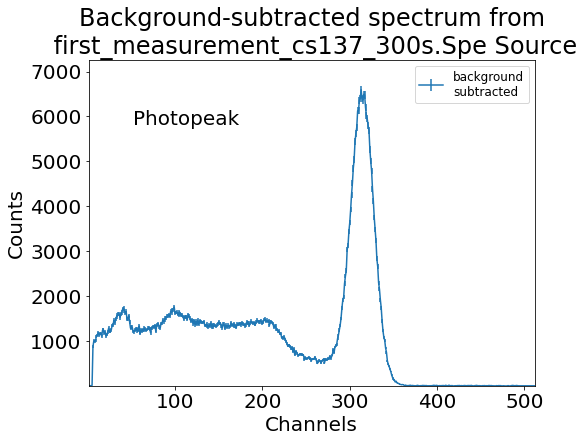

In [68]:
# Plot the background-subtracted spectrum in channel space

figuretitle   = 'Background-subtracted spectrum from\n '+ inputfile1 + ' Source' # set title for the graph
xlabeltext    = "Channels"                                                       # set x-axis label
ylabeltext    = "Counts"                                                         # set y-axis label
annotatetext1 = "Photopeak"                                                      # set text for annotation 1
yaxistype     = "linear"                                                         # choose 'log' or 'linear' for yscale

# select plotting symbols

symbol1='g.'       # choose colour and symbol for foreground data points ('r.', 'go', 'bD', etc.)
symbol2='r.'       # choose colour and symbol for background data points 
symbol3='b.'       # choose colour and symbol for subtracted data points 

# find minimum and maximum x- and y-values in the data to be plotted

xcountsmin=min(channel)
xcountsmax=max(channel)
ycountsmin=min(yield1)
ycountsmax=max(yield1)

# set minimum and maximum scales for x- and y-axes

xplotmin=xcountsmin
xplotmax=xcountsmax
yplotmin=0.1                  # set non-zero value to avoid error if logarithmic y-axis chosen
yplotmax=ycountsmax*1.1

# set location for annotation

annotatexposition1 = xplotmin+0.1*(xplotmax-xplotmin) # use fraction between 0 and 1 to ensure position is within plot area
annotateyposition1 = yplotmin+0.8*(yplotmax-yplotmin) # use fraction between 0 and 1 to ensure position is within plot area

# plot and save the graph

plt.yscale(yaxistype)                                                   # plot 'log' or 'linear' for yscale
plt.rcParams['font.family'] = 'DejaVu Sans'                             # set font style for labels 
plt.rcParams['font.size'] = 20                                          # set font size for labels
plt.rcParams["figure.figsize"] = (8,6)                                  # set figure size (x,y) in inches
plt.axis([xplotmin, xplotmax, yplotmin, yplotmax])                      # plot the graph axes
plt.xlabel(xlabeltext)                                                  # add label for x-axis
plt.ylabel(ylabeltext)                                                  # add label for y-axis
plt.title(figuretitle)                                                  # add figure title
# plt.errorbar(channel,yield1,yerr=error1)                              # plot foreground data
# plt.errorbar(channel,yield2,yerr=error2)                              # plot background data
plt.errorbar(channel,yield3,yerr=error3,label="background\nsubtracted") # plot background-subtracted data
plt.legend(loc=1,prop={'size': 12})                                     # add legend to plot, locate upper right
plt.annotate(annotatetext1,xy=(annotatexposition1,annotateyposition1))  # Sample annotation of graph
plt.savefig(outputfile1,bbox_inches = 'tight')                          # write out spectra to outputfile
plt.show()

In [69]:
# inital guess at parameters of fit

# range of fit (channels)

xfitlower = 270                     # lower x-limit of fit (in channels)
xfitupper = 350                     # upper x-limit of fit (in channels)

# parameters of peak

amplitude = 7000                   # initial guess at amplitude
centroid  = 315                     # initial guess at centroid (in channels)
FWHM      = 30.0                    # initial guess at full width half maximum (FWHM) (in channels) 

# background terms (recommend starting from zero)

constant  = 0.0                     # initial value of constant background term
linear    = 0.0                     # initial value of linear background term
quadratic = 0.0                     # initial value of quadratic background term

<ipython-input-70-00256be96fdd>:68: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-x0)**2/(2*sigma**2))+const+lin*x+quad*x*x
<ipython-input-70-00256be96fdd>:68: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-x0)**2/(2*sigma**2))+const+lin*x+quad*x*x


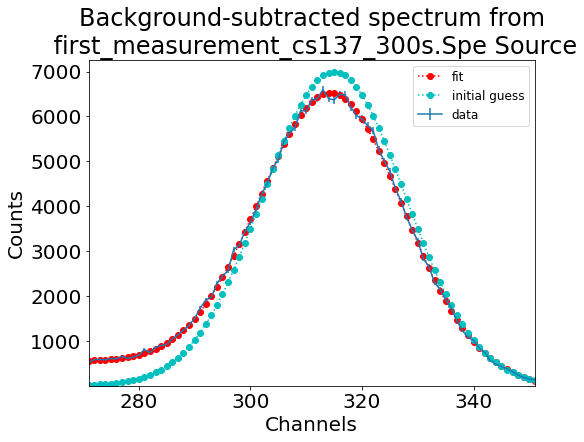

In [70]:
sigma=FWHM/2.355                    # calculate sigma from FWHM
params  = [amplitude,centroid,sigma,constant,linear,quadratic] # array for initial fit parameters

# set up arrays for the data to be fitted

nofitpoints = xfitupper - xfitlower + 1

xfitdata    = np.array([x for x in range(nofitpoints)],'i')
xfitdatae   = np.array([x for x in range(nofitpoints)],'f')
yfitdata    = np.array([x for x in range(nofitpoints)],'i')
yerrfitdata = np.array([x for x in range(nofitpoints)],'f')

# fill the arrays with the data to be fitted

count=0
while count<nofitpoints:
    count2=count+xfitlower
    xfitdata[count]=channel[count2]
    yfitdata[count]=yield3[count2]
    yerrfitdata[count]=error3[count2]
    count += 1
    
# define the Gaussian plus background function to be fitted
     # x is the data ordinate
     # the remaining arguments are the function parameters:
          # a is the amplitude
          # x0 is the centroid
          # sigma is the standard deviation
          # const is constant background
          # lin is linear background term
          #quad is quadratic background term  

def gaus(x,a,x0,sigma,const,lin,quad):
    return a*exp(-(x-x0)**2/(2*sigma**2))+const+lin*x+quad*x*x
sigma=FWHM/2.355                    # calculate sigma from FWHM
params  = [amplitude,centroid,sigma,constant,linear,quadratic] # array for initial fit parameters

# set up arrays for the data to be fitted

nofitpoints = xfitupper - xfitlower + 1

xfitdata    = np.array([x for x in range(nofitpoints)],'i')
xfitdatae   = np.array([x for x in range(nofitpoints)],'f')
yfitdata    = np.array([x for x in range(nofitpoints)],'i')
yerrfitdata = np.array([x for x in range(nofitpoints)],'f')

# fill the arrays with the data to be fitted

count=0
while count<nofitpoints:
    count2=count+xfitlower
    xfitdata[count]=channel[count2]
    yfitdata[count]=yield3[count2]
    yerrfitdata[count]=error3[count2]
    count += 1
    
# define the Gaussian plus background function to be fitted
     # x is the data ordinate
     # the remaining arguments are the function parameters:
          # a is the amplitude
          # x0 is the centroid
          # sigma is the standard deviation
          # const is constant background
          # lin is linear background term
          #quad is quadratic background term  

def gaus(x,a,x0,sigma,const,lin,quad):
    return a*exp(-(x-x0)**2/(2*sigma**2))+const+lin*x+quad*x*x

# define a quadratic background function
     # x is the data ordinate
     # the remaining arguments are the function parameters:
          # const is constant background
          # lin is linear background term
          #quad is quadratic background term  

def background(x,const,lin,quad):
    return const+lin*x+quad*x*x

# fit the function to the data
     # gaus is the function to be fitted
     # x is the data crdinate
     # y is the data co-ordinate
     # params is a list of the inital guesses at the parameter values
     # sigma is error in the co-ordinate data
        
popt,pcov = curve_fit(gaus,xfitdata,yfitdata,p0=params,sigma=yerrfitdata)

# plot the fit

xplotmin = min(xfitdata)
xplotmax = max(xfitdata)

plt.axis([xplotmin, xplotmax, yplotmin, yplotmax])                       # plot the graph axes
plt.xlabel(xlabeltext)                                                   # add label for x-axis
plt.ylabel(ylabeltext)                                                   # add label for y-axis
plt.title(figuretitle)                                                   # add figure title
plt.errorbar(xfitdata,yfitdata,yerr=yerrfitdata,label='data')            # plot original data
plt.plot(xfitdata,gaus(xfitdata,*popt),'ro:',label='fit')                # plot fitted function
plt.plot(xfitdata,gaus(xfitdata,*params),'co:',label='initial guess')    # plot initial function
plt.legend(loc=1,prop={'size': 12})                                      # add legend to plot, locate upper right
plt.show()                                                               # plot the graph


In [71]:
# calculate output values
# amplitude, integral, centroid, standard deviation, and full width at half maximum (FWHM).

amplitude = popt[0]
centroid  = popt[1]
sigma     = popt[2]
constant  = popt[3]
linear    = popt[4]
quadratic = popt[5]
integral  = 2.5066*amplitude*sigma
FWHM      = 2.355*sigma

perr = np.sqrt(np.diag(pcov))

amplitudeerror = perr[0]
centroiderror  = perr[1]
sigmaerror     = perr[2]
FWHMerror      = 2.355*sigmaerror
integralerror  = math.sqrt((amplitudeerror**2)/(amplitude**2)+(sigmaerror**2)/(sigma**2))*integral

params2 = [constant,linear,quadratic]      # array for plotting fitted background parameters

# print out peak parameters in channel space

print('Peak amplitude          is ', np.around(amplitude,decimals=2),u"\u00B1",np.around(amplitudeerror,decimals=2),'    counts')
print('Peak integral (net)     is ', np.around(integral,decimals=2),u"\u00B1",np.around(integralerror,decimals=2),' counts')
print('Peak centroid           is ', np.around(centroid,decimals=2),u"\u00B1",np.around(centroiderror,decimals=2),'      channels')
print('Peak standard deviation is ', np.around(sigma,decimals=2),u"\u00B1",np.around(sigmaerror,decimals=2),'        channels')
print('Peak FWHM               is ', np.around(FWHM,decimals=2),u"\u00B1",np.around(FWHMerror,decimals=2),'      channels')

Peak amplitude          is  6141.78 ± 53.73     counts
Peak integral (net)     is  196696.24 ± 2355.56  counts
Peak centroid           is  314.46 ± 0.05       channels
Peak standard deviation is  12.78 ± 0.1         channels
Peak FWHM               is  30.09 ± 0.25       channels


In [72]:
# inital guess at parameters of fit for Compton Edge

# range of fit (channels)

xfitlower = 150                     # lower x-limit of fit (in channels)
xfitupper = 250                     # upper x-limit of fit (in channels)

# parameters of peak

edgeposition  = 205                 # initial estimate of Compton edge position (in channels)
edgeamplitude = 1600               # initial guess at amplitude of Compton edge
diffuseness   = 10                  # initial guess at diffuseness parameter of Compton edge (in channels)

# background terms (recommend starting from zero)

constant  = 0.0                     # initial value of constant background term
linear    = 0.0                     # initial value of linear background term
quadratic = 0.0                     # initial value of quadratic background term

<ipython-input-73-c81dd0064f55>:36: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return (constant+linear*x+quadratic*x*x)+(edgeamplitude/(1+exp((x-edgeposition)/diffuseness)))
<ipython-input-73-c81dd0064f55>:36: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return (constant+linear*x+quadratic*x*x)+(edgeamplitude/(1+exp((x-edgeposition)/diffuseness)))


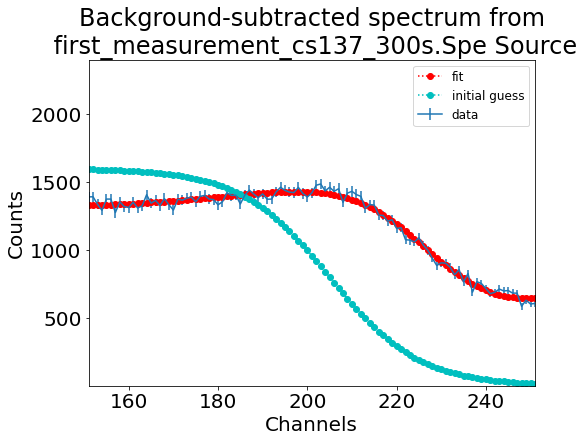

In [73]:
edgeparams  = [edgeposition,edgeamplitude,diffuseness,constant,linear,quadratic] # array for initial edgefit parameters

# set up arrays for the data to be fitted

nofitpoints = xfitupper - xfitlower + 1

xfitdatac    = np.array([x for x in range(nofitpoints)],'i')
yfitdatac    = np.array([x for x in range(nofitpoints)],'i')
yerrfitdatac = np.array([x for x in range(nofitpoints)],'f')

# fill the arrays with the data to be fitted

count=0
while count<nofitpoints:
    count2=count+xfitlower
    xfitdatac[count]=channel[count2]
    yfitdatac[count]=yield3[count2]
    yerrfitdatac[count]=error3[count2]
    count += 1
    
# define the Compton Edge plus background parameterisation to be fitted
     # x is the data ordinate
     # the next three arguments are the amplitude and parameters of the 2pF (two-parameter Fermi) distribution:
          # edgeposition is x-position half-way down the compton edge (channels)
          # edgeamplitude is the amplitude of the Compton electron distribution (counts)
          # diffuseness parameter (channels)
              # twice the diffuseness parameter corresponds to the range of x over which the function falls 
              # from 73% to 27% of its maximum value
     # the next three parameters are a quadratic background:
          # constant is a constant background (counts)
          # linear is a linear background term 
          # quadratic is a quadratic background term  
     # the function fitted is a standard two-parameter Fermi distribution   

def edge(x,edgeposition,edgeamplitude,diffuseness,constant,linear,quadratic):
    return (constant+linear*x+quadratic*x*x)+(edgeamplitude/(1+exp((x-edgeposition)/diffuseness)))

# define a quadratic background function
     # x is the data ordinate
     # the remaining arguments are the function parameters:
          # const is constant background
          # lin is linear background term
          # quad is quadratic background term  

def background(x,const,lin,quad):
    return const+lin*x+quad*x*x

# fit the function to the data
     # edge is the function to be fitted
     # x is the data crdinate
     # y is the data co-ordinate
     # params is a list of the inital guesses at the parameter values
     # sigma is error in the co-ordinate data
        
popt,pcov = curve_fit(edge,xfitdatac,yfitdatac,p0=edgeparams,sigma=yerrfitdatac)

# plot the fit

xplotmin = min(xfitdatac)
xplotmax = max(xfitdatac)
yplotmax = 1.5*edgeamplitude

plt.axis([xplotmin, xplotmax, yplotmin, yplotmax])                       # plot the graph axes
plt.xlabel(xlabeltext)                                                   # add label for x-axis
plt.ylabel(ylabeltext)                                                   # add label for y-axis
plt.title(figuretitle)                                                   # add figure title
plt.errorbar(xfitdatac,yfitdatac,yerr=yerrfitdatac,label='data')         # plot original data
plt.plot(xfitdatac,edge(xfitdatac,*popt),'ro:',label='fit')              # plot fitted function
plt.plot(xfitdatac,edge(xfitdatac,*edgeparams),'co:',label='initial guess') # plot initial function
plt.legend(loc=1,prop={'size': 12})                                      # add legend to plot, locate upper right
plt.show()                                                               # plot the graph

In [74]:
# calculate output values
# Position, Amplitude and error in position

ComptonEdgePosition      = popt[0]
Comptonamplitude         = popt[1]
Diffuseness              = popt[2]

perr = np.sqrt(np.diag(pcov))

ComptonEdgePositionerror = perr[0]
Diffusenesserror         = perr[2]

# input energy calibration and actual peak energy, if known.

calibrationgradient = 3.48   # units of keV/channel 
calibrationoffset   = 2      # units of keV
peakenergy          = 662    # known peak energy in keV

# convert Comptone endge position to keV

ComptonEdgePositionE = ComptonEdgePosition*calibrationgradient + calibrationoffset             # Compton Edge in keV
ComptonEdgePositionerrorE = ComptonEdgePositionerror*calibrationgradient                       # Error in keV
DiffusenessE = Diffuseness*calibrationgradient                                                 # Diffuseness in keV
DiffusenesserrorE = Diffusenesserror*calibrationgradient                                       # Error in keV


# print out peak parameters in energy space

print('Half-way down Compton Edge is ', np.around(ComptonEdgePositionE,decimals=2),u"\u00B1",np.around(ComptonEdgePositionerrorE,decimals=2),' keV')
print('Diffuseness parameter is      ', np.around(DiffusenessE,decimals=2),u"\u00B1",np.around(DiffusenesserrorE,decimals=2),' keV')


Half-way down Compton Edge is  791.63 ± 3.75  keV
Diffuseness parameter is       32.6 ± 5.71  keV
